# Jakob's Handy Dandy Development Notebook

## combo lock and wordle.

In [1]:
# comibination lock setting
"""
First off, changing the reward function. I'll try changing it to be backwards. cool seems to work. just had to add 
  +custom_reward_function.path=/home/jbjorner3/storage/dev/dev_verl/verl/verl/utils/reward_score/jakob_gsm8k.py, and change up a bit the compute_score function header
Move to GRPO on the GSM8K setting. see this https://verl.readthedocs.io/en/latest/experiment/ppo.html
Move to a larger model (Q: how does batch size work, how does the trainer load the data? 
                        A: they seem to specify generation from batch size specified in the dataset args
                           then they have ppo_mini_batch_size and ppo_micro_batch_size_per_gpu
                        seems to be the ppo trainer by default doesn't use no_sync unless you use the megatron trainer.
                        I should default to the megatron trainer then.
                        )
Create dataset in the below format. (get Instruct 3B model working -- might try base eventually. 
  Not necessary for experiments. Just performance perhaps, but only would work with large base models potentially.)
  -- Chat template seems to be required. Not sure how this works??? 
TODO: find out how the async batching works, does trainer.batch_size get generated from the same checkpoint and then fed into the ppo trainer with minibatches and grad accumulation on subsets?
      or is something else going on?
TODO: find out if the generation thing between hugggingface and sglang for the chat template is a bad thing for the results of SGLang.
TODO: Find out training time for 7B instruct -- finding for A100 SXM node with default sglang script. Then need to move to getting 3B up with GRPO.
TODO: make training prompt for 3B instruct model (make one with criteria filtering and one with just feedback more redundant. This to test out the hypothesis from Aly's doc.)
    -- using gemini prompt with instruct model I get (59+68)/(200+200) awesome! the base model gets (11+8)/(187+192) across two runs. Ohh shit. 
       I realize that the pass at 256 people are likely using instruct models.  Also the pass at 256 inference idea surely doesn't measure what you need for good down stream performance. 
       this greedy strategy doesn't take into account diversity.
       pass@256 people don't use base models meaning that they aren't able to get much more out of the representation space as its collapsed a bit too much.
TODO: make training script for 3B model for gsm8k and show results. (doing this first as it requires time...)
TODO: raise batch size, and other things for 3b instruct model


{'data_source': 'openai/gsm8k',
 'prompt': [{'content': 'Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers\' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers\' market? Let\'s think step by step and output the final answer after "####".',
             'role': 'user'}],
 'ability': 'math',
 'reward_model': {'ground_truth': '18', 'style': 'rule'},
 'extra_info': {'answer': 'Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.\nShe makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.\n#### 18',
  'index': 0,
  'question': "Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?",
  'split': 'test'}}

{'data_source': 'openai/gsm8k',
 'prompt': [{'content': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May? Let\'s think step by step and output the final answer after "####".',
   'role': 'user'}],
 'ability': 'math',
 'reward_model': {'ground_truth': '72', 'style': 'rule'},
 'extra_info': {'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72',
  'index': 0,
  'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
  'split': 'train'}}

new data format to try.
{'prompt': [{'content': 'Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers\' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers\' market? Let\'s think step by step and output the final answer after "####".',
             'role': 'user'}],
 'reward_model': {'ground_truth': '18'},
 'extra_info': {'answer': 'Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.\nShe makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.\n#### 18',
  'index': 0,
  'question': "Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?",
  'split': 'test'}}
"""

'\nFirst off, changing the reward function. I\'ll try changing it to be backwards. cool seems to work. just had to add \n  +custom_reward_function.path=/home/jbjorner3/storage/dev/dev_verl/verl/verl/utils/reward_score/jakob_gsm8k.py, and change up a bit the compute_score function header\nMove to GRPO on the GSM8K setting. see this https://verl.readthedocs.io/en/latest/experiment/ppo.html\nMove to a larger model (Q: how does batch size work, how does the trainer load the data? \n                        A: they seem to specify generation from batch size specified in the dataset args\n                           then they have ppo_mini_batch_size and ppo_micro_batch_size_per_gpu\n                        seems to be the ppo trainer by default doesn\'t use no_sync unless you use the megatron trainer.\n                        I should default to the megatron trainer then.\n                        )\nCreate dataset in the below format. (get Instruct 3B model working -- might try base eventuall

In [11]:
# game of combinations lock with no repeated numbers.
from itertools import permutations
import torch
import random

def get_feedback_str(guess, target):
    feedback_str = "" # ⬜🟨⬜🟩⬜
    for c_t, c_g in zip(target, guess):
        if c_t == c_g:
            feedback_str += "🟩"
        elif c_g in target:
            feedback_str += "🟨"
        else:
            feedback_str += "⬜"
    return feedback_str

class ComboLockGame:
    def __init__(self, code_len=3, max_turns=8, seed=42):
        self.data = list(permutations(range(10), code_len))
        data = self.data
        print("data size", len(data))
        train_data, val_data, test_data = torch.utils.data.random_split(data, lengths=[0.8,0.1,0.1], generator=torch.random.manual_seed(seed))
        self.train_data, self.val_data, self.test_data = list(train_data), list(val_data), list(test_data)
        self.lock_code = (1,2,3)
        self.max_turns = max_turns
        self.current_turn = 0
    def reset(self, seed=None, game_possible_words='all'):
        lock_codes = {'all':self.data, 'train':self.train_data, 'val':self.val_data, 'test':self.test_data}[game_possible_words]
        rng = random.Random(seed)

        self.lock_code = rng.choice(lock_codes)
        self.current_turn = 0
        observation = ""
        info = None
        return observation, info
    def step(self, action: tuple[int,...]):
        feedback_str: str = get_feedback_str(action, self.lock_code)
        self.current_turn += 1
        if action == self.lock_code:
            terminated = True
            reward = 1
        else:
            terminated = self.current_turn == self.max_turns
            reward = -1 if not terminated else -10

        observation = {"current_turn": self.current_turn, "feedback_str": feedback_str}
        truncated = False
        info = None
        return observation, reward, terminated, truncated, info
class Criteria:
    def __init__(self):
        # types of feedback. 
        # W is in the word and in the correct spot.
        # I is in the word but in the wrong spot.
        # U is not in the word in any spot.
        self.contained: set[tuple[int,...]] = set()
        self.located: dict = dict()
        self.not_contained: set = set()
    #     self.guesses: list = list()
    # def add_guess(self, guess, target):
        # "⬜🟨⬜🟩⬜" I could add guesses to help verbalize the guesses and feedback for a langauge model instead of giving the LLM the full support every time.
        # 
        # ...
    def is_supported(self, word):
        # assert len(word) == 5, "word must be 5 chars long"
        for p, c in self.located.items():
            if word[p] != c:
                return False
        for p, c in self.contained:
            if c not in word:
                return False
            if word[p] == c:
                return False
        for c in self.not_contained:
            if c in word:
                return False
        return True
    def __repr__(self):
        return f"Criteria(contained={self.contained}, located={self.located}, not_contained={self.not_contained})"
    def __add__(self, other):
        new_contained = self.contained | other.contained
        new_located = self.located | other.located
        new_not_contained = self.not_contained | other.not_contained
        new_criteria = Criteria()
        new_criteria.contained = new_contained
        new_criteria.located = new_located
        new_criteria.not_contained = new_not_contained
        return new_criteria

def get_criteria(guess, target):
    criteria: Criteria = Criteria()
    for i, (c_t, c_g) in enumerate(zip(target, guess)):
        if c_t == c_g:
            criteria.located[i] = c_t
        elif c_g in target:
            criteria.contained.add((i, c_g))
        else:
            criteria.not_contained.add(c_g)
    return criteria

def find_new_support(support: list[str], criteria: Criteria):
    new_support = []
    for word in support:
        if criteria.is_supported(word):
            new_support.append(word)
    return new_support
# game = ComboLockGame()
# game.reset()
# print(f"{game.lock_code=}")
# def is_valid_guess(guess: str):
#     if len(guess) != 3:
#         return False
#     return True
# process_input = lambda input_str: tuple(int(c) for c in input_str)
# terminated = False
# while not terminated:
#     guess = input("what is your next guess?")
#     if guess == "q":
#         break
#     while not is_valid_guess(guess):
#         guess = input(f"Invalid guess {guess}. What is your next guess?").lower()
#         if guess == "q":
#             break
#     if guess == 'q':
#         break
#     guess = process_input(guess)
#     observation, reward, terminated, truncated, info = game.step(guess)
#     feedback = observation['feedback_str']
#     step_num = observation['current_turn']
#     print(f"Guess #{step_num}: {guess} -> {feedback}")
#     if reward == 1:
#         print('won')
#         break
#     if terminated:
#         print("lost")
#         break

In [12]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-3B-Instruct") 
# tokenizer.tokenize("123") # just verify that they have independant tokens per number.

In [17]:
import pickle
import random
data = pickle.load(open("single_turn_data.pkl", 'rb'))
# defining this again here, because it might change from above.
def get_feedback_str(guess, target):
    feedback_str = "" # ⬜🟨⬜🟩⬜
    for c_t, c_g in zip(target, guess):
        if c_t == c_g:
            feedback_str += "🟩"
        elif c_g in target:
            feedback_str += "🟨"
        else:
            feedback_str += "⬜"
    return feedback_str
def format_guesses(guesses, target, random_ordering=True, include_prompt=False, add_true_guess=False, for_prompt=False):
    formatted_guesses = "You are to unlock a 3 digit lock. Numbers are not used more than once in this lock.\nFor each guess, you get feedback in the form of emojis\n⬜ meaning the number guessed isn't in the combo\n🟨 meaning the number guessed is in the combo but in the wrong position\n🟩 meaning the number guessed is in the combo and is in the right position\n" if include_prompt else ""
    guesses = list(guesses) # new object so inplace shuffle doesn't do anything weird.
    if random_ordering:
        random.shuffle(guesses)
    step_num = 0
    for guess in guesses:
        step_num += 1
        guess_str = ''.join(str(i) for i in guess)
        feedback_str = get_feedback_str(guess, target)
        formatted_guesses += f"Guess #{step_num}: {guess_str} -> {feedback_str}\n"
    if add_true_guess:
        step_num += 1
        target_str = ''.join(str(i) for i in target)
        feedback_str = get_feedback_str(target, target)
        formatted_guesses += f"Final Guess: {target_str} -> {feedback_str}\n"
    if for_prompt:
        formatted_guesses += f"Final Guess:"

    return formatted_guesses
    
def format_cot_guess(guesses, target, random_ordering=True, prompt_style=0):
    if prompt_style == 0:
        formatted_guesses = ("You are to unlock a 3 digit lock. Numbers are not used more than once in this lock.\n"
                            "You are given the feedback from previous attempts at unlocking. The feedback is in the form of emojis\n"
                            "⬜ meaning the number guessed isn't in the correct combination\n"
                            "🟨 meaning the number guessed is in the correction combination but in the wrong position\n"
                            "🟩 meaning the number guessed is in the correct combination and is in the right position\n")
        format_function = lambda guess_str, feedback_str: f"Guess {guess_str} -> Feedback {feedback_str}\n"
        end_prompt = ("From the above guesses and feedback, you should be able to determine the exact combination. Think step by step, and when you are confident denote your final answer with Answer: XXX\n"
                      "Lets break this down step by step")
    elif prompt_style == 1:
        formatted_guesses = ("A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer.\n"
                            "User: You are to unlock a 3 digit lock. Numbers are not used more than once in this lock.\n"
                            "You are given the feedback from previous attempts at unlocking.\n")
                            # "Guess 764 -> Feedback 7 is not present in the true combination, 6 is not present in the true combination, 4 is not present in the true combination\n"
                            # "Guess 329 -> Feedback 3 is not present in the true combination, 2 is not present in the true combination, 9 is present and is in the correct location with respect to the true combination\n"
                            # "Guess 526 -> Feedback 5 is not present in the true combination, 2 is not present in the true combination, 6 is not present in the true combination\n"
                            # "Guess 805 -> Feedback 8 is not present in the true combination, 0 is present and is in the correct location with respect to the true combination, 5 is not present in the true combination\n"
                            # "Guess 046 -> Feedback 0 is present but not in the correct location with respect to the true combination, 4 is not present in the true combination, 6 is not present in the true combination\n"
        def format_function(guess_str, feedback_str): 
            feedback_list = []
            feedback_map = {"⬜": "is not present in the true combination",
                            "🟨": "is present but not in the correct location with respect to the true combination",
                            "🟩": "is present and is in the correct location with respect to the true combination"}
            for c_g, c_f in zip(guess_str, feedback_str):
                feedback_list.append(f"{c_g} {feedback_map[c_f]}")
            
            return f"Guess {guess_str} -> Feedback {', '.join(feedback_list)}\n"
        end_prompt = ("From the above guesses and feedback, you should be able to determine the exact combination. Show your work in <think> </think> tags. And return the final answer in <answer> </answer> tags, for example <answer> 123 </answer>.\n"
                      "Assistant: Let me solve this step by step.")
    elif prompt_style == 2:
        formatted_guesses = ("A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer.\n"
                            "\n"
                            "User: You are a meticulous detective solving a lock-picking case. Your single goal is to determine the exact 3-digit combination using a precise, step-by-step deduction process."
                            "\n"
                            "The Case File:\n"
                            "\n"
                            "The Lock: Requires a 3-digit combination with three unique digits.\n"
                            "Your Goal: Determine the combination for [Position 1, Position 2, Position 3].\n"
                            "Forensic Evidence (Clues from previous attempts):\n"
                            "\n")
        def format_function(guess_str, feedback_str): 
            feedback_list = []
            feedback_map = {"⬜": "is NOT in the combination",
                            "🟨": "IS in the combination but IS IN THE WRONG position",
                            "🟩": "IS in the combination and IS in the correct position"}
            for i, (c_g, c_f) in enumerate(zip(guess_str, feedback_str)):
                feedback_list.append(f"Analysis of '{c_g}' in Position {i+1}: The digit '{c_g}' {feedback_map[c_f]}")
            feedback_str_joined = '\n'.join(feedback_list)
            return f"Evidence: The guess was {guess_str}\n\n{feedback_str_joined}\n"
        end_prompt = ("Inside <think> tags show your deductions.\n"
                      "Synthesize and Solve: Combine all your conclusions to state the final combination.\n"
                      "Final Verification: Before giving the answer, check your proposed combination against every piece of feedback from the Evidence to ensure it is 100% consistent.\n"
                      "After this rigorous process, provide the final 3-digit number inside <answer> tags.\n"
                      "Assistant:")
    elif prompt_style == 3:
        # posterior crocodile alogator
        formatted_guesses = ("A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer.\n"
                            "\n"
                            "User: You are a meticulous detective solving a lock-picking case. Your single goal is to determine the exact 3-digit combination using a precise, step-by-step deduction process."
                            "\n"
                            "The Case File:\n"
                            "\n"
                            "The Lock: Requires a 3-digit combination with three unique digits.\n"
                            "Your Goal: Determine the combination for [Position 1, Position 2, Position 3].\n"
                            "Forensic Evidence (Clues from previous attempts):\n"
                            "\n")
        criteria = Criteria()
        for guess in guesses:
            criteria += get_criteria(guess, target)
        print(criteria)
        if len(criteria.not_contained) != 0:
            for not_contained_char in criteria.not_contained:
                formatted_guesses += f"- {not_contained_char} IS NOT in the combination\n"
        if len(criteria.contained) != 0:
            for (not_position, contained_char) in criteria.contained:
                formatted_guesses += f"- {contained_char} IS in the combination but IS NOT in position {not_position+1}\n"
        if len(criteria.located) != 0:
            for yes_position, contained_char in criteria.located.items():
                formatted_guesses += f"- {contained_char} IS in the combination AND IS in position {yes_position+1}\n"
        def format_function(*args):
            return ""
        end_prompt = ("Inside <think> tags show your deductions.\n"
                      "Synthesize and Solve: Combine all your conclusions to state the final combination.\n"
                      "Final Verification: Before giving the answer, check your proposed combination against every piece of feedback from the Evidence to ensure it is 100% consistent.\n"
                      "After this rigorous process, provide the final 3-digit number inside <answer> tags.\n"
                      "Assistant:")

    else:
        raise NotImplementedError("invalid prompt style")
    guesses = list(guesses)
    if random_ordering:
        random.shuffle(guesses)
    step_num = 0
    for guess in guesses:
        step_num += 1
        guess_str = ''.join(str(i) for i in guess)
        feedback_str = get_feedback_str(guess, target)
        formatted_guesses += format_function(guess_str, feedback_str) # 
    formatted_guesses += end_prompt
    return formatted_guesses
prompts, targets = zip(*data)
test_index = 9
sample_prompt = format_cot_guess(prompts[test_index], targets[test_index], prompt_style=2)
def convert_base_prompt_to_chat_prompt(base_prompt):
    chat_prompt = base_prompt.split("User: ")[1].split("\nAssistant")[0].strip()
    return [{"role": 'user',
            "content": chat_prompt}]
from pprint import pprint
pprint(convert_base_prompt_to_chat_prompt(sample_prompt))
targets[test_index]

pprint(format_cot_guess(prompts[test_index], targets[test_index], prompt_style=3))

[{'content': 'You are a meticulous detective solving a lock-picking case. Your '
             'single goal is to determine the exact 3-digit combination using '
             'a precise, step-by-step deduction process.\n'
             'The Case File:\n'
             '\n'
             'The Lock: Requires a 3-digit combination with three unique '
             'digits.\n'
             'Your Goal: Determine the combination for [Position 1, Position '
             '2, Position 3].\n'
             'Forensic Evidence (Clues from previous attempts):\n'
             '\n'
             'Evidence: The guess was 318\n'
             '\n'
             "Analysis of '3' in Position 1: The digit '3' is NOT in the "
             'combination\n'
             "Analysis of '1' in Position 2: The digit '1' IS in the "
             'combination and IS in the correct position\n'
             "Analysis of '8' in Position 3: The digit '8' IS in the "
             'combination but IS IN THE WRONG position\n'
     

In [18]:
# formatting all the data into a parquet and preparing it for training. Wait, can a 0.5 B instruct model work for this task? Answer: not with the current prompt setup.
# prompts, targets = zip(*data)
from datasets import Dataset
# Dataset.from_dict({'h':[123], "e":[32]})
# train_dataset = train_dataset.map(function=make_map_fn("train"), with_indices=True)
# test_dataset = test_dataset.map(function=make_map_fn("test"), with_indices=True)

# local_dir = args.local_dir
# hdfs_dir = args.hdfs_dir

# train_dataset.to_parquet(os.path.join(local_dir, "train.parquet"))
# test_dataset.to_parquet(os.path.join(local_dir, "test.parquet"))
dataset_dict_for_parquet = {
    'data_source': [],
    "prompt": [],
    "reward_model": [],
    "extra_info": [],
}
prompt_style = 3
for i, (prompt, target) in enumerate(zip(prompts, targets)):
    prompt_formatted = format_cot_guess(prompt, target, prompt_style=prompt_style)
    dataset_dict_for_parquet['data_source'] += ['jakob_custom_func']
    dataset_dict_for_parquet['prompt'] += [convert_base_prompt_to_chat_prompt(prompt_formatted)]
    dataset_dict_for_parquet['reward_model'] += [{'ground_truth': target}]
    dataset_dict_for_parquet['extra_info'] += [{'base_prompt_info': prompt, "index": i}]
ds = Dataset.from_dict(dataset_dict_for_parquet)
ds = ds.train_test_split(0.1,0.9, seed=42)
ds_train = ds['train']
ds_test = ds['test']

ds_train.to_parquet("/nas/ucb/jbjorner3/data/single_turn_combo_lock_posterior/train.parquet")
ds_test.to_parquet("/nas/ucb/jbjorner3/data/single_turn_combo_lock_posterior/test.parquet")
from pprint import pprint
pprint(ds_train[0])

Criteria(contained={(0, 0)}, located={1: 0, 2: 9}, not_contained={2, 3, 4, 5, 6, 7, 8})
Criteria(contained={(2, 2)}, located={1: 0, 2: 8}, not_contained={1, 4, 5, 6, 7, 9})
Criteria(contained={(1, 6), (2, 0), (0, 6)}, located={1: 0, 0: 8}, not_contained={1, 2, 3, 5, 7})
Criteria(contained=set(), located={0: 3, 1: 2}, not_contained={0, 1, 4, 5, 6, 8, 9})
Criteria(contained={(1, 1)}, located={2: 1, 0: 4, 1: 0}, not_contained={2, 3, 5, 6, 8, 9})
Criteria(contained={(1, 3), (0, 5)}, located={1: 2, 2: 5}, not_contained={0, 1, 4, 6, 7, 8, 9})
Criteria(contained={(1, 8), (2, 2)}, located={1: 7, 2: 8}, not_contained={0, 1, 3, 4, 5, 9})
Criteria(contained={(2, 9), (0, 0), (0, 8), (1, 9), (2, 8)}, located={0: 9, 2: 0}, not_contained={1, 3, 5, 7})
Criteria(contained={(1, 1)}, located={0: 7, 1: 3}, not_contained={2, 4, 5, 6, 8, 9})
Criteria(contained={(2, 8)}, located={2: 5, 1: 1}, not_contained={2, 3})
Criteria(contained={(1, 9), (2, 7)}, located={1: 0, 2: 9}, not_contained={1, 2, 3, 4, 5, 8})
Cr

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

{'data_source': 'jakob_custom_func',
 'extra_info': {'base_prompt_info': [[3, 7, 0],
                                     [6, 4, 5],
                                     [4, 1, 2],
                                     [4, 5, 1],
                                     [2, 8, 3],
                                     [7, 8, 6],
                                     [2, 0, 4]],
                'index': 1286},
 'prompt': [{'content': 'You are a meticulous detective solving a lock-picking '
                        'case. Your single goal is to determine the exact '
                        '3-digit combination using a precise, step-by-step '
                        'deduction process.\n'
                        'The Case File:\n'
                        '\n'
                        'The Lock: Requires a 3-digit combination with three '
                        'unique digits.\n'
                        'Your Goal: Determine the combination for [Position 1, '
                        'Position 2, P

In [16]:
dataset_dict_for_parquet

{'data_source': ['jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_func',
  'jakob_custom_fun

In [14]:
max([len(c[0]['content']) for c in dataset_dict_for_parquet['prompt']])
# dataset_dict_for_parquet['prompt'][0][]

1317

In [ ]:
import datasets


In [6]:
# list(sorted((len(prompt), index, prompt) for index, prompt in enumerate(prompts)))

In [20]:
# come up with single turn verl enviornment config and get it training with minimal adjustments.
# something single turn could be a setting with a single combo lock narrowed down from the options.
# how do I generate these single turn enviornments? given some target (1,2,3), what guesses narrow it to one option?
# we can say only one support remains, so there is like a set of up to 7 feedbacks which restrict all other options.
# necessarily these up to 7 other guesses aren't exactly the same as the target, but they may intersect.
# you need more than yellow 

In [23]:
# dataset prep
# !wget https://gist.githubusercontent.com/dracos/dd0668f281e685bad51479e5acaadb93/raw/6bfa15d263d6d5b63840a8e5b64e04b382fdb079/valid-wordle-words.txt
import torch
import random
data_unfiltered = open('valid-wordle-words.txt', 'r').readlines()
def filter_word(word):
    # don't repeat letters this makes the game hard to code.
    return len(set(word)) == len(word)
data = [d for d in data_unfiltered if filter_word(d[:-1])]
print('total filtered words:', len(data))
print("words removed:", len(data_unfiltered) - len(data))
# train_data = random_split
train_data, val_data, test_data = torch.utils.data.random_split(data, lengths=[0.8,0.1,0.1], generator=torch.random.manual_seed(42))
open("filtered-valid-wordle-words.txt", 'w').writelines(data)
open("train-valid-wordle-words.txt", 'w').writelines(train_data)
open("val-valid-wordle-words.txt", 'w').writelines(val_data)
open("test-valid-wordle-words.txt", 'w').writelines(test_data)
remove_nl = lambda l: [li.strip() for li in l]
train_data, val_data, test_data = list(remove_nl(train_data)), list(remove_nl(val_data)), list(remove_nl(test_data))
data = list(remove_nl(data))
print(list(data)) # good words: speir, lythe, rangs, ables

total filtered words: 9365
words removed: 5490
['abeng', 'abers', 'abets', 'abeys', 'abhor', 'abide', 'abies', 'abius', 'abjud', 'abled', 'abler', 'ables', 'ablet', 'ablow', 'abmho', 'abnet', 'abode', 'abohm', 'aboil', 'abord', 'abore', 'aborn', 'abort', 'about', 'above', 'abrim', 'abrin', 'abris', 'absey', 'absit', 'abune', 'aburn', 'abuse', 'abuts', 'abyes', 'abysm', 'acedy', 'acerb', 'acers', 'ached', 'acher', 'aches', 'achey', 'acids', 'acidy', 'acies', 'acing', 'acker', 'acmes', 'acned', 'acnes', 'acoel', 'acold', 'acone', 'acorn', 'acred', 'acres', 'acrid', 'acron', 'acros', 'acryl', 'acted', 'actin', 'acton', 'actor', 'actus', 'acute', 'acyls', 'adbot', 'adept', 'adhoc', 'adieu', 'adios', 'adits', 'adlib', 'admen', 'admin', 'admit', 'admix', 'adnex', 'adobe', 'adopt', 'adorb', 'adore', 'adorn', 'adown', 'adoze', 'adret', 'adrip', 'adsum', 'aduki', 'adult', 'adunc', 'adust', 'advew', 'advts', 'adyts', 'adzes', 'aegis', 'aeons', 'aeros', 'aesir', 'aevum', 'afion', 'afire', 'aflow'

In [ ]:
# game of wordle with no repeated characters.
game_possible_words = data
def get_feedback_str(guess, target):
    feedback_str = "" # ⬜🟨⬜🟩⬜
    for c_t, c_g in zip(target, guess):
        if c_t == c_g:
            feedback_str += "🟩"
        elif c_g in target:
            feedback_str += "🟨"
        else:
            feedback_str += "⬜"
    return feedback_str
target = random.choice(game_possible_words)
def is_valid_guess(guess: str):
    if len(guess) != 5:
        return False
    # if guess.lower() not in game_possible_words:
    #     return False
    return True
print(f"{target=}")
for i in range(6):
    guess = input("what is your next guess?").lower()
    if guess == "q":
        break
    while not is_valid_guess(guess):
        guess = input(f"Invalid guess {guess}. What is your next guess?").lower()
        if guess == "q":
            break
    if guess == 'q':
        break
    feedback = get_feedback_str(guess, target)
    print(f"Guess #{i+1}: {guess} -> {feedback}")
    if guess == target:
        print("won")
        break
    if i == 5:
        print("lost")

target='galut'
Guess #1: print -> ⬜⬜⬜⬜🟩


In [2]:
# how do I formally come up with the best first word in wordle? 
# this is a tree search problem right? well its something.
# I guess the first word: picks, based on how many words it eliminates or. 
# we start with a uniform prior over all 14855 words
# Then in a pragmatic way we reduce the possibility space, are we trying to increase the probability of the answer? 
# well. we know the probability of any word is 1/14855 before we start, and nothing we do will change that. 
# we can only eliminate some words from the possibility space. 
# like if they we know that some letter is not included, or that some letter must be at a particular spot.
# this feels a lot like a set cover problem with guesses connecting to a maximal number of words. maybe the edges are characters shared between them.
# this isn't exactly right tho. The characters which are within your word are how you get feedback, so you want to remove characters. 
# if you had some character which was in every word, you would gain no information from using that character.
# if you had a character which partitioned the set of choices exactly, then including that word would be great, 
# further the position information you get about that word would help you get more than just 1/2 the support eliminated.
# if you knew that when the word is included that the position of its inclusion would partition the set further, 
# then you would try to optimally position this character.
# then you balance these choices with all characters in your string to reduce your set optimally. 
# But I guess if you reduce your set to a set which isn't nice to reduce, then you've screwed yourself doing the greedy thing.
# there is a simplified version of wordle. lets call it set wordle, we do this to reduce wordle to a set covering. 
# Perhaps because it isn't the exact same its an invalid heuristic, but whatever.
# looking for a node in the graph and we only get to probe the graph and see if this node is neighbors with the target.
# kind of a binary search. find nodes which partition the search, and which allow for further paritioning information gain style.
# what is the information gain of the word (in decision trees information gain doesn't necessarily tell you everything because sometimes there are two zero information gain decisions, but they can lead to partitions which have high information gain in themselves.)
# lets talk about the support (it sounds nice).
# initial support is 14855
# then you guess and what is the smallest support you can achieve after the first guess?
# I can just enumerate over all possible words.

$min_{word} max_{target} (len support(feedback(word, target)))$

In [ ]:
# this cell is me trying to calculate optimal word for wordle and realizing it seems intractible. And in python the first greedy information gathering layer is also too slow with O(n**3).

# assuming all possible targets, what is the minimum_word max_targets{len newsupport(allwords, criteria(word, target))} ? 
# this is a 9365 * 9365 sized problem 87,703,225 words and to calculate the new support takes O(9365) again so really 
# 821,340,702,125 python string operations. which is going to be slow...

# new_support = find_new_support(data, get_criteria('words', "tarts"))
# len(new_support), len(data)
# criteria: Criteria = Criteria()
# criteria.located['e'] = 3
# criteria.contained.update(set('epr'))
# criteria.not_contained.update(set('qustinkflagsboxd'))
# find_new_support(data, criteria)


# trying a bunch of options for finding support in the combo lock setting
from itertools import permutations
import random
data = list(permutations(range(10), 3))
single_turn_data = []
for _ in range(10000):
    target = random.choice(data)
    criteria = Criteria()
    guesses = []
    for i in range(7):
        guess = random.choice(data)
        guesses += [guess]
        criteria += get_criteria(guess, target)

        new_support = find_new_support(data, criteria)
        if len(new_support) == 1:
            # print(target, guesses)
            if target in guesses:
                pass
            else:
                single_turn_data += [(guesses, target)]
            break
        # I would like to get the function which maps from the set of supported answers to the set of guesses with feedback which could have lead to this support.
        # this seems hard. will just randomly search for it.

In [114]:
len(single_turn_data)
import pickle
pickle.dump(
    single_turn_data,
    open("single_turn_data.pkl", 'wb')
)

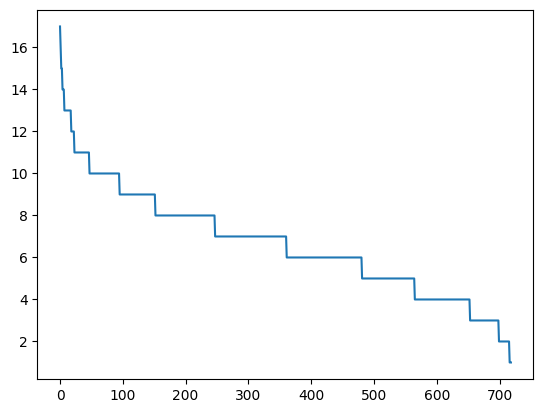

In [115]:
from collections import Counter
import matplotlib.pyplot as plt
c = Counter(j for _,j in single_turn_data)
plt.plot(sorted(c.values(), reverse=True))

## SGLANG server for qwen2.5 3b

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3,5"
from sglang.test.test_utils import is_in_ci
from sglang.utils import wait_for_server, print_highlight, terminate_process

if is_in_ci():
    from patch import launch_server_cmd
else:
    from sglang.utils import launch_server_cmd

# This is equivalent to running the following command in your terminal

# python3 -m sglang.launch_server --model-path qwen/qwen2.5-0.5b --host 0.0.0.0
model_name = "Qwen/Qwen2.5-3B-Instruct" # "Qwen/QwQ-32B"
tp_size = (len(os.environ["CUDA_VISIBLE_DEVICES"]) + 1) // 2
server_process, port = launch_server_cmd(
    f"""
python3 -m sglang.launch_server --model-path {model_name} --host 0.0.0.0 
"""# --tp {tp_size} mem_fraction_static=0.4 
)
wait_for_server(f"http://localhost:{port}")

[2025-06-02 15:55:03] server_args=ServerArgs(model_path='Qwen/Qwen2.5-3B-Instruct', tokenizer_path='Qwen/Qwen2.5-3B-Instruct', tokenizer_mode='auto', skip_tokenizer_init=False, load_format='auto', trust_remote_code=False, dtype='auto', kv_cache_dtype='auto', quantization=None, quantization_param_path=None, context_length=None, device='cuda', served_model_name='Qwen/Qwen2.5-3B-Instruct', chat_template=None, completion_template=None, is_embedding=False, enable_multimodal=None, revision=None, host='0.0.0.0', port=32498, mem_fraction_static=0.88, max_running_requests=None, max_total_tokens=None, chunked_prefill_size=8192, max_prefill_tokens=16384, schedule_policy='fcfs', schedule_conservativeness=1.0, cpu_offload_gb=0, page_size=1, tp_size=1, pp_size=1, max_micro_batch_size=None, stream_interval=1, stream_output=False, random_seed=12821049, constrained_json_whitespace_pattern=None, watchdog_timeout=300, dist_timeout=None, download_dir=None, base_gpu_id=0, gpu_id_step=1, log_level='info', l

In [2]:
from openai import OpenAI
client = OpenAI(api_key="None", base_url=f"http://0.0.0.0:{port}/v1")
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
# prompt = "How many r in strawberry."
# messages = [
#     {"role": "system", "content": "You are a helpful and harmless assistant. You are Qwen developed by Alibaba. You should think step-by-step."},
#     {"role": "user", "content": prompt}
# ]
# text = tokenizer.apply_chat_template(
#     messages,
#     tokenize=False,
#     add_generation_prompt=True
# )
# res = client.completions.create(model=model_name, prompt=[text] * 100, max_tokens=10000)
# res.choices


In [3]:
# print(res.choices[0].text)
# max(len(tokenizer.tokenize(c.text)) for c in res.choices)

In [ ]:
# prompt = "What is your first guess for wordle today: "
# longer prompt from the paper https://arxiv.org/pdf/2504.20997
# '''You are an agent playing a customized version of the game Wordle. There is a five-letter target word from the
# English dictionary which you must try to guess as quickly as possible. The target word does not contain any repeated
# letters. You will incrementally construct your guess for this target word by selecting one letter of the alphabet at each
# timestep. For each letter you guess, you will be given feedback indicating if the guessed letter is either in the correct
# position for the target word, in the wrong position for the target word, or does not appear in the target word at all.
# You will receive a reward of one if your guessed word correctly matches the target word. Otherwise, rewards will
# always be zero. Your only available actions are letters of the alphabet.'''
num_attempts = 200

if "Instruct" not in model_name and "Chat" not in model_name: 
    print("using base model")
    sample_prompt_temp = """A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer.

    User: You are a meticulous detective solving a lock-picking case. Your single goal is to determine the exact 3-digit combination using a precise, step-by-step deduction process.

    The Case File:

    The Lock: Requires a 3-digit combination with three unique digits.
    Your Goal: Determine the combination for [Position 1, Position 2, Position 3].
    Forensic Evidence (Clues from previous attempts):

    Evidence A: The guess was 235

    Analysis of '2' in Position 1: The digit '2' is NOT in the combination.
    Analysis of '3' in Position 2: The digit '3' is NOT in the combination.
    Analysis of '5' in Position 3: The digit '5' IS in the combination and IS in the correct position (Position 3).
    Evidence B: The guess was 318

    Analysis of '3' in Position 1: The digit '3' is NOT in the combination (confirms previous data).
    Analysis of '1' in Position 2: The digit '1' IS in the combination and IS in the correct position (Position 2).
    Analysis of '8' in Position 3: The digit '8' IS in the combination but IS IN THE WRONG position (i.e., it is not in Position 3).
    Inside <think> tags show your deductions.
    Synthesize and Solve: Combine all your conclusions to state the final combination.
    Final Verification: Before giving the answer, check your proposed combination against every piece of feedback from Evidence A and B to ensure it is 100% consistent.
    After this rigorous process, provide the final 3-digit number inside <answer> tags.

    Assistant:"""
else:
    print("using Instruct/Chat model")
    sample_prompt_temp = """You are a meticulous detective solving a lock-picking case. Your single goal is to determine the exact 3-digit combination using a precise, step-by-step deduction process.

The Case File:

The Lock: Requires a 3-digit combination with three unique digits.
Your Goal: Determine the combination for [Position 1, Position 2, Position 3].
Forensic Evidence (Clues from previous attempts):

Evidence A: The guess was 235

Analysis of '2' in Position 1: The digit '2' is NOT in the combination.
Analysis of '3' in Position 2: The digit '3' is NOT in the combination.
Analysis of '5' in Position 3: The digit '5' IS in the combination and IS in the correct position (Position 3).
Evidence B: The guess was 318

Analysis of '3' in Position 1: The digit '3' is NOT in the combination (confirms previous data).
Analysis of '1' in Position 2: The digit '1' IS in the combination and IS in the correct position (Position 2).
Analysis of '8' in Position 3: The digit '8' IS in the combination but IS IN THE WRONG position (i.e., it is not in Position 3).
Inside <think> tags show your deductions.
Synthesize and Solve: Combine all your conclusions to state the final combination.
Final Verification: Before giving the answer, check your proposed combination against every piece of feedback from Evidence A and B to ensure it is 100% consistent.
After this rigorous process, provide the final 3-digit number inside <answer> tags."""

    # sample_prompt_temp = sample_prompt
    messages = [
        {"role": "system", "content": "You are a helpful and harmless assistant. You are Qwen developed by Alibaba. You should think step-by-step."},
        {"role": "user", "content": sample_prompt_temp}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    sample_prompt_temp = text

res = client.completions.create(model=model_name, prompt=[sample_prompt_temp] * num_attempts, max_tokens=1000, stop=["</answer>","</ans>"])
print("PROMPT:", sample_prompt_temp)
# target = targets[test_index]
target_str = "815"# ''.join(str(c) for c in target) # "109" # 
print("TARGET ANSWER:", target_str)
successes = 0
successful_formats = 0
for choice in res.choices:
    print("-"*10)
    def get_answer_from_cot(answer_string):
        import re
        # answer_prefixes = ["Answer:", "<answer>", 'answer:', '<ans>']
        answer = "".join(re.findall(r"\d", answer_string)[-3:])

        if len(answer) == 3: # this is more permissive just take the last 3 digits from whatever is spit out. that way we don't penalize for formatting.
            # answer_start_index = answer_string.index(answer_prefix) + len(answer_prefix)
            # want really to extract the last 3 numbers from whatever format I specify.
            return answer
        return False
    if get_answer_from_cot(choice.text):
        successful_formats += 1
        if get_answer_from_cot(choice.text) == target_str:
            successes += 1
            print("SUCCESS MATCH:", choice.text, target_str)
        else:
            print("FAILED MATCH:", choice.text)
    else:
        print('FAIL:', choice.text)

    # This was for few shot prompting, but I realize I should use CoT.
    # if choice.text.strip().isnumeric():
    #     if choice.text.strip().isnumeric() == target_str:
    #         print("SUCCESS MATCH:", choice.text.strip(), target_str)
    #     else:
    #         print("FAILED MATCH:", choice.text.strip())

    # else:
    #     print('FAIL:', choice.text)
# inject distracting infromation such that the reasoning model cannot do it.
# Some big reasoning model fails.
# Then a prompted posterior generated from a small model showing that this works better than the reasoning model would be what we want.
'''1 is contained in the right position. (position 1)
a tomato is possibly a fruit.
2 is not contained in the lock.
3 is not contained in the lock.
3 is greater than 1.
a pineapple is a fruit.
1 is still in the right position.

What is your next guess.

ask for what the next belief over the possible combinations, and then prompt it with '''
print(successes, successful_formats)

using Instruct/Chat model
[2025-06-02 15:55:57] Prefill batch. #new-seq: 1, #new-token: 396, #cached-token: 0, token usage: 0.00, #running-req: 0, #queue-req: 0
[2025-06-02 15:55:57] Prefill batch. #new-seq: 2, #new-token: 792, #cached-token: 0, token usage: 0.00, #running-req: 1, #queue-req: 0
[2025-06-02 15:55:57] Prefill batch. #new-seq: 100, #new-token: 100, #cached-token: 39500, token usage: 0.00, #running-req: 3, #queue-req: 0
2025-06-02 15:55:57,772 - INFO - flashinfer.jit: Loading JIT ops: cascade
2025-06-02 15:56:15,049 - INFO - flashinfer.jit: Finished loading JIT ops: cascade
[2025-06-02 15:56:15] Prefill batch. #new-seq: 97, #new-token: 97, #cached-token: 38315, token usage: 0.00, #running-req: 103, #queue-req: 0
[2025-06-02 15:56:16] Decode batch. #running-req: 200, #token: 6996, token usage: 0.01, cuda graph: False, gen throughput (token/s): 222.54, #queue-req: 0
[2025-06-02 15:56:17] Decode batch. #running-req: 200, #token: 14996, token usage: 0.01, cuda graph: False, ge

In [4]:
client.completions.create?

Signature:
client.completions.create(
    *,
    model: "Union[str, Literal['gpt-3.5-turbo-instruct', 'davinci-002', 'babbage-002']]",
    prompt: 'Union[str, List[str], Iterable[int], Iterable[Iterable[int]], None]',
    best_of: 'Optional[int] | NotGiven' = NOT_GIVEN,
    echo: 'Optional[bool] | NotGiven' = NOT_GIVEN,
    frequency_penalty: 'Optional[float] | NotGiven' = NOT_GIVEN,
    logit_bias: 'Optional[Dict[str, int]] | NotGiven' = NOT_GIVEN,
    logprobs: 'Optional[int] | NotGiven' = NOT_GIVEN,
    max_tokens: 'Optional[int] | NotGiven' = NOT_GIVEN,
    n: 'Optional[int] | NotGiven' = NOT_GIVEN,
    presence_penalty: 'Optional[float] | NotGiven' = NOT_GIVEN,
    seed: 'Optional[int] | NotGiven' = NOT_GIVEN,
    stop: 'Union[Optional[str], List[str], None] | NotGiven' = NOT_GIVEN,
    stream: 'Optional[Literal[False]] | Literal[True] | NotGiven' = NOT_GIVEN,
    stream_options: 'Optional[ChatCompletionStreamOptionsParam] | NotGiven' = NOT_GIVEN,
    suffix: 'Optional[str] | NotG

## playing with chat template prompting

In [1]:
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"
model_name = "Qwen/Qwen2.5-0.5B-Instruct" # "Qwen/Qwen2.5-0.5B" #
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map='auto')

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [2]:
chat_prompt = [{'role': "user", 'content':"hello there"}]
prompt_chat_str = tokenizer.apply_chat_template(chat_prompt, add_generation_prompt=True, tokenize=False)
out = model.generate(**tokenizer(prompt_chat_str, return_tensors="pt", add_special_tokens=False).to('cuda'), )

In [3]:
print(tokenizer.decode(out[0]))

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
hello there<|im_end|>
<|im_start|>assistant
Hello! How can I assist you today? If you have any questions or need help with something specific


In [12]:
# import requests

# response = requests.post(
#     f"http://localhost:{port}/generate",
#     json={
#         "text": "The capital of France is",
#         "sampling_params": {
#             "temperature": 0,
#             "max_new_tokens": 320,
#         },
#     },
# )

# print_highlight(response.json())